In [1]:
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from scipy.misc import imread
import pandas
import numpy as np

In [2]:
#Code borrowed from scikit-learn example: http://bit.ly/2AsddsF
def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

In [3]:
#Load in dataset
df = pandas.read_csv('yemen_filtered_events.csv')
print(df.describe())

                  id  relid         year  type_of_violence  conflict_dset_id  \
count     625.000000    0.0   625.000000         625.00000         625.00000   
mean   211864.612800    NaN  2015.328000           1.11360        1871.84640   
std     10220.306419    NaN     0.469861           0.33716        4555.01516   
min    203839.000000    NaN  2015.000000           1.00000         230.00000   
25%    204855.000000    NaN  2015.000000           1.00000         230.00000   
50%    205816.000000    NaN  2015.000000           1.00000         230.00000   
75%    217796.000000    NaN  2016.000000           1.00000         230.00000   
max    234947.000000    NaN  2016.000000           3.00000       14611.00000   

       conflict_new_id  dyad_dset_id  dyad_new_id  side_a_dset_id  \
count       625.000000     625.00000    625.00000      625.000000   
mean       1771.696000   14390.85600  14395.58560      176.307200   
std        4270.574246    1697.49378   1658.56455      185.790028   
min

In [4]:
#Compute difference between combatant and civilian deaths by location
differences = np.sign(df.loc[:, 'combatant_deaths'] - df.loc[:, 'deaths_civilians'])
difference_signs = np.sign(differences)
df['differences'] = difference_signs

In [8]:
#Get two-class data
difference_data = df[df.differences != 0]
coordinates = difference_data.loc[:, ['longitude', 'latitude']]
selected_differences = difference_data.loc[:,'differences']
assert(len(coordinates) == len(selected_differences))
print(len(coordinates))

#Instantiate support vector machine, fit
#TODO: add cross-validation for C selection
#TODO: separate training, test data so we have a sense of accuracy
C = 2.0 
model = svm.SVC(kernel='rbf', gamma=0.7, C=C)
model.fit(coordinates, selected_differences)

543


SVC(C=2.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.7, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

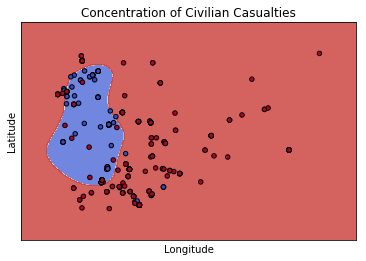

In [6]:
#Plot support vector machine (again, mostly derived from http://bit.ly/2AsddsF)

# Set-up 2x2 grid for plotting.
# plt.subplots_adjust(wspace=2, hspace=2)

#Create meshgrid, plot
X0, X1 = coordinates.loc[:, 'longitude'], coordinates.loc[:, 'latitude']
xx, yy = make_meshgrid(X0, X1)

plt.figure(figsize=(20,100))
fig, ax = plt.subplots(1, 1)

plot_contours(plt, model, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(X0, X1, c=selected_differences, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_xticks(())
ax.set_yticks(())
ax.set_title("Concentration of Civilian Casualties")

plt.show()

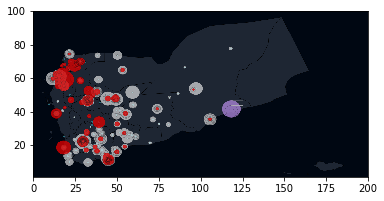

In [14]:
#Load in map as background image, plot
img = imread('qgis/yemen/map.png')
plt.imshow(img, zorder=0, extent=[0, 200, 1.0, 100])
plt.show()